In [2]:
"""
Unit 5: Evolving Your IPD Agent with Genetic Algorithms
========================================================

In Unit 4, you hand-coded agent strategies like Tit-for-Tat.
In Unit 5, you'll use evolution to DISCOVER strategies automatically.

By the end, you'll have an evolved agent saved as a JSON file for the tournament!
"""

# ============================================================================
# SETUP: Import everything from previous units
# ============================================================================

import random
import numpy as np
import json
import matplotlib.pyplot as plt
from agents import Agent, INVEST, UNDERCUT
from game_engine import Game, Tournament

# Import all hand-coded agents from Unit 4
from agents import (
    AlwaysInvestAgent, AlwaysUndercutAgent, TitForTatAgent,
    GrimTriggerAgent, PavlovAgent, TitForTwoTatsAgent,
    GenerousTitForTatAgent, AdaptiveAgent, RandomAgent,
    SuspiciousTitForTatAgent, GradualAgent, HardMajorityAgent,
    SoftMajorityAgent, ProberAgent
)

print("✅ Imports complete!")

✅ Imports complete!


In [4]:

# ============================================================================
# PART 1: THE EVOLVABLE AGENT (PROVIDED - Read but don't modify)
# ============================================================================

class EvolvableAgent(Agent):
    """
    An agent whose strategy is controlled by 6 genes (numbers from 0 to 1).
    
    Think of genes as "strategy dials" you can tune:
    
    Gene[0] - Initial Cooperation (0=hostile start, 1=friendly start)
    Gene[1] - Cooperation Response (if opponent cooperates, how likely to cooperate back?)
    Gene[2] - Defection Response (if opponent defects, how likely to defect back?)
    Gene[3] - Forgiveness (after retaliation, chance to forgive)
    Gene[4] - Memory Length (0=last 1 round, 1=last 10 rounds)
    Gene[5] - Retaliation Threshold (what % of defections triggers retaliation)
    """
    
    def __init__(self, genes=None, name="Evolved Agent"):
        if genes is None:
            # Create random genes if none provided
            genes = [random.random() for _ in range(6)]
        
        self.genes = genes
        super().__init__(name, f"Genes: [{', '.join([f'{g:.2f}' for g in genes])}]")
    
    def choose_action(self) -> bool:
        """Decision logic based on genes - SIMPLIFIED FOR LEARNING"""
        
        # First 3 rounds: use initial cooperation gene
        if self.round_num < 3:
            return random.random() < self.genes[0]
        
        # Calculate memory window (gene[4])
        memory_length = max(1, int(self.genes[4] * 10) + 1)
        recent_history = self.history[-memory_length:]
        
        # Calculate opponent's recent COOPERATION rate (not defection!)
        cooperation_rate = sum(recent_history) / len(recent_history)
        
        # If opponent is mostly cooperating, reciprocate
        if cooperation_rate >= 0.5:
            return random.random() < self.genes[1]  # gene[1] = cooperate response
        
        # If opponent is mostly defecting, retaliate or forgive
        else:
            # Retaliate with probability gene[2]
            if random.random() < self.genes[2]:
                return UNDERCUT
            # Or forgive with probability gene[3]
            elif random.random() < self.genes[3]:
                return INVEST
            else:
                return UNDERCUT


In [5]:

# ============================================================================
# PART 2: DEFINE THE OPPONENT ECOSYSTEM
# ============================================================================

# ============================================================================
# EXPANDED OPPONENT POOL
# ============================================================================

# Full pool of all possible opponents
full_opponent_pool = [
    # Cooperative agents
    AlwaysInvestAgent(),
    TitForTatAgent(),
    GrimTriggerAgent(),
    PavlovAgent(),
    TitForTwoTatsAgent(),
    GenerousTitForTatAgent(),
    AdaptiveAgent(),
    
    # Aggressive agents
    AlwaysUndercutAgent(),
    SuspiciousTitForTatAgent(),
    
    # Sophisticated agents
    GradualAgent(),
    ProberAgent(),
    
    # Majority-based agents
    HardMajorityAgent(),
    SoftMajorityAgent(),
    
    # Random agents with different cooperation levels
    RandomAgent(0.9),
    RandomAgent(0.7),
    RandomAgent(0.5),
    RandomAgent(0.3),
    RandomAgent(0.1),
]

print(f"\n📚 Full opponent library: {len(full_opponent_pool)} agents available")

# For initial evolution, randomly sample opponents
opponent_pool = random.sample(full_opponent_pool, 10)

print(f"🎲 Randomly selected {len(opponent_pool)} opponents for this evolution:")
for i, opp in enumerate(opponent_pool, 1):
    print(f"  {i:2d}. {opp.name:25s} - {opp.description}")
print("="*70)




📚 Full opponent library: 18 agents available
🎲 Randomly selected 10 opponents for this evolution:
   1. Random (0.5)              - Randomly invests 50% of the time
   2. Suspicious Tit-for-Tat    - Starts hostile, then copies opponent
   3. Random (0.9)              - Randomly invests 90% of the time
   4. Gradual                   - Escalates punishment after each betrayal
   5. Pavlov                    - Win-Stay-Lose-Shift strategy
   6. Hard Majority             - Defects if opponent defects >50% of time
   7. Random (0.7)              - Randomly invests 70% of the time
   8. Tit-for-Two-Tats          - Tolerates one betrayal, retaliates after two
   9. Soft Majority             - Cooperates if opponent cooperates >=50% of time
  10. Adaptive                  - Adapts to opponent's cooperation rate


In [6]:

# ============================================================================
# PART 3: GENETIC ALGORITHM FUNCTIONS (YOUR TODO!)
# ============================================================================

def initialize_population(pop_size):
    """
    Create initial population of random agents.
    
    Args:
        pop_size: Number of agents in population
    
    Returns:
        List of EvolvableAgent objects with random genes
    """
    population = []
    for i in range(pop_size):
        agent = EvolvableAgent(name=f"Agent_{i}")
        population.append(agent)
    return population


def evaluate_fitness(agent, opponents, num_rounds=50):
    """
    Measure how good an agent is by playing against all opponents.
    
    Args:
        agent: The EvolvableAgent to evaluate
        opponents: List of opponent agents to play against
        num_rounds: Number of rounds per game
    
    Returns:
        Float: Average score per game (higher is better)
    """
    total_score = 0
    num_games = 0
    
    for opponent in opponents:
        game = Game(agent, opponent, num_rounds=num_rounds)
        score, _ = game.play()
        total_score += score
        num_games += 1
    
    avg_score = total_score / num_games
    return avg_score


def tournament_selection(population, fitnesses, tournament_size=3):
    """
    Select parents using tournament selection.
    
    Tournament selection:
    1. Pick tournament_size random individuals
    2. Choose the one with best fitness
    3. Repeat until we have pop_size selected parents
    
    Args:
        population: List of agents
        fitnesses: List of fitness scores (parallel to population)
        tournament_size: How many agents compete in each tournament
    
    Returns:
        List of selected agents (same length as population)
    """
    # TODO: Implement tournament selection
    # Hint: Use random.sample() to pick contestants
    # Hint: Use max() with a key function to find the best
    # Hint: Don't forget to make copies of genes!
    
    # PLACEHOLDER: Just randomly select agents (NO SELECTION PRESSURE!)
    '''
    selected = []
    for _ in range(len(population)):
        random_agent = random.choice(population)
        selected.append(EvolvableAgent(genes=random_agent.genes.copy()))
    
    return selected
    '''

    selected = []
    
    for _ in range(len(population)):
        # Pick random contestants
        contestants_idx = random.sample(range(len(population)), tournament_size)
        
        # Find the one with best fitness
        best_idx = max(contestants_idx, key=lambda i: fitnesses[i])
        
        # Add winner to selected (make a copy of genes)
        winner_genes = population[best_idx].genes.copy()
        selected.append(EvolvableAgent(genes=winner_genes))
    
    return selected


def crossover_and_mutate(parent1, parent2, mutation_rate=0.15):
    """
    Create a child from two parents using crossover and mutation.
    
    Crossover (single-point):
    1. Pick a random split point (1 to 5)
    2. Take genes before split from parent1
    3. Take genes after split from parent2
    
    Mutation:
    1. For each gene, with probability=mutation_rate:
    2. Add Gaussian noise (mean=0, std=0.2)
    3. Clip gene to stay in range [0, 1]
    
    Args:
        parent1: First parent EvolvableAgent
        parent2: Second parent EvolvableAgent
        mutation_rate: Probability of mutating each gene
    
    Returns:
        New EvolvableAgent (the child)
    """
    # TODO: Implement crossover
    # Hint: Use random.randint(1, 5) for crossover point
    # Hint: Use list slicing: parent1.genes[:point] + parent2.genes[point:]
    
    # TODO: Implement mutation
    # Hint: Use random.random() < mutation_rate for each gene
    # Hint: Use random.gauss(0, 0.2) for noise
    # Hint: Use max(0.0, min(1.0, value)) to clip
    
    '''
    # PLACEHOLDER: Just return a random child (NO GENETIC INHERITANCE!)
    child_genes = [random.random() for _ in range(6)]
    
    return EvolvableAgent(genes=child_genes)
    '''

    # Crossover
    crossover_point = random.randint(1, 5)  # Random split between 1 and 5
    child_genes = (parent1.genes[:crossover_point] + 
                   parent2.genes[crossover_point:])
    
    # Mutation
    for i in range(len(child_genes)):
        if random.random() < mutation_rate:
            # Add random noise
            child_genes[i] += random.gauss(0, 0.2)
            # Keep gene in valid range [0, 1]
            child_genes[i] = max(0.0, min(1.0, child_genes[i]))
    
    return EvolvableAgent(genes=child_genes)


def evolve(generations=25, pop_size=20, opponents=None, mutation_rate=0.15, elitism=2):
    """
    Run the genetic algorithm to evolve an agent.
    
    Process:
    1. Create initial random population
    2. For each generation:
       a. Evaluate fitness of all agents
       b. Select parents via tournament selection
       c. Create children via crossover & mutation
       d. Keep best agents (elitism)
    3. Return the best agent found
    
    Args:
        generations: Number of generations to evolve
        pop_size: Size of population
        opponents: List of opponents to evaluate against
        mutation_rate: Probability of gene mutation
        elitism: Number of best agents to keep unchanged
    
    Returns:
        Best EvolvableAgent found
    """
    if opponents is None:
        opponents = opponent_pool
    
    print(f"\n🧬 EVOLUTION STARTING")
    print(f"{'='*70}")
    print(f"Population: {pop_size} | Generations: {generations} | Mutation: {mutation_rate}")
    print(f"Opponents: {len(opponents)} | Elitism: {elitism}")
    print(f"{'='*70}\n")
    
    # Track statistics
    best_fitness_history = []
    avg_fitness_history = []
    
    # Initialize population
    population = initialize_population(pop_size)
    
    best_overall_agent = None
    best_overall_fitness = -float('inf')
    
    # Evolution loop
    for gen in range(generations):
        # Evaluate fitness for all agents
        fitnesses = []
        for agent in population:
            fitness = evaluate_fitness(agent, opponents, num_rounds=50)
            fitnesses.append(fitness)
        
        # Track best and average
        # Track best and average
        best_fitness = max(fitnesses)
        avg_fitness = sum(fitnesses) / len(fitnesses)
        best_fitness_history.append(best_overall_fitness)
        avg_fitness_history.append(avg_fitness)

        # Sanity check: best fitness should never decrease (elitism guarantee)
        if gen > 0 and best_fitness < best_fitness_history[gen-1]:
            print(f"⚠️  WARNING: Best fitness decreased from {best_fitness_history[gen-1]:.2f} to {best_fitness:.2f}")
            print(f"    This suggests a bug in elitism or fitness evaluation!")
        
        # Track best agent ever seen
        # Track best agent ever seen
        best_idx = fitnesses.index(best_fitness)
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            # CRITICAL: Make a deep copy so genes don't get mutated later
            best_overall_agent = EvolvableAgent(genes=population[best_idx].genes.copy())
        
        # Print progress
        print(f"Gen {gen+1:3d}/{generations}: "
              f"Best={best_fitness:6.2f} | Avg={avg_fitness:6.2f} | "
              f"Genes={[f'{g:.2f}' for g in population[best_idx].genes]}")
        
        # Create next generation (unless this is the last generation)
        if gen < generations - 1:
            # Sort population by fitness for elitism
            sorted_indices = sorted(range(len(fitnesses)), 
                                  key=lambda i: fitnesses[i], 
                                  reverse=True)
            
            # Keep elite agents (top performers)
            next_population = []
            for i in range(elitism):
                elite_genes = population[sorted_indices[i]].genes.copy()
                next_population.append(EvolvableAgent(genes=elite_genes))
            
            # Selection
            selected = tournament_selection(population, fitnesses)
            
            # Create offspring to fill rest of population
            while len(next_population) < pop_size:
                parent1, parent2 = random.sample(selected, 2)
                child = crossover_and_mutate(parent1, parent2, mutation_rate)
                next_population.append(child)
            
            population = next_population
    
    print(f"\n{'='*70}")
    print(f"✅ EVOLUTION COMPLETE!")
    print(f"🏆 Best fitness achieved: {best_overall_fitness:.2f}")
    print(f"{'='*70}\n")
    
    # Plot evolution progress
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, generations+1), best_fitness_history, 
             label='Best Fitness', linewidth=2, color='green', marker='o')
    plt.plot(range(1, generations+1), avg_fitness_history, 
             label='Average Fitness', linewidth=2, color='blue', marker='s', alpha=0.7)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness (Avg Score per Game)', fontsize=12)
    plt.title('Evolution Progress', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_overall_agent




🚀 TIME TO EVOLVE YOUR AGENT!

🧬 EVOLUTION STARTING
Population: 30 | Generations: 100 | Mutation: 0.1
Opponents: 10 | Elitism: 2

Gen   1/100: Best=144.60 | Avg=126.66 | Genes=['0.22', '0.49', '0.00', '0.79', '0.87', '0.01']
Gen   2/100: Best=146.40 | Avg=132.23 | Genes=['0.93', '0.70', '0.02', '0.66', '0.76', '0.27']
Gen   3/100: Best=145.80 | Avg=137.00 | Genes=['0.93', '0.70', '0.13', '0.45', '0.00', '0.37']
⚠️  WARNING: Best fitness decreased from 146.40 to 145.40
    This suggests a bug in elitism or fitness evaluation!
Gen   4/100: Best=145.40 | Avg=140.04 | Genes=['0.93', '0.70', '0.13', '0.45', '0.00', '0.90']
⚠️  WARNING: Best fitness decreased from 146.40 to 145.90
    This suggests a bug in elitism or fitness evaluation!
Gen   5/100: Best=145.90 | Avg=139.75 | Genes=['0.93', '0.70', '0.13', '0.45', '0.00', '0.37']
Gen   6/100: Best=147.00 | Avg=138.44 | Genes=['0.93', '0.70', '0.13', '0.45', '0.27', '0.37']
Gen   7/100: Best=153.50 | Avg=139.51 | Genes=['1.00', '0.46', '0.26

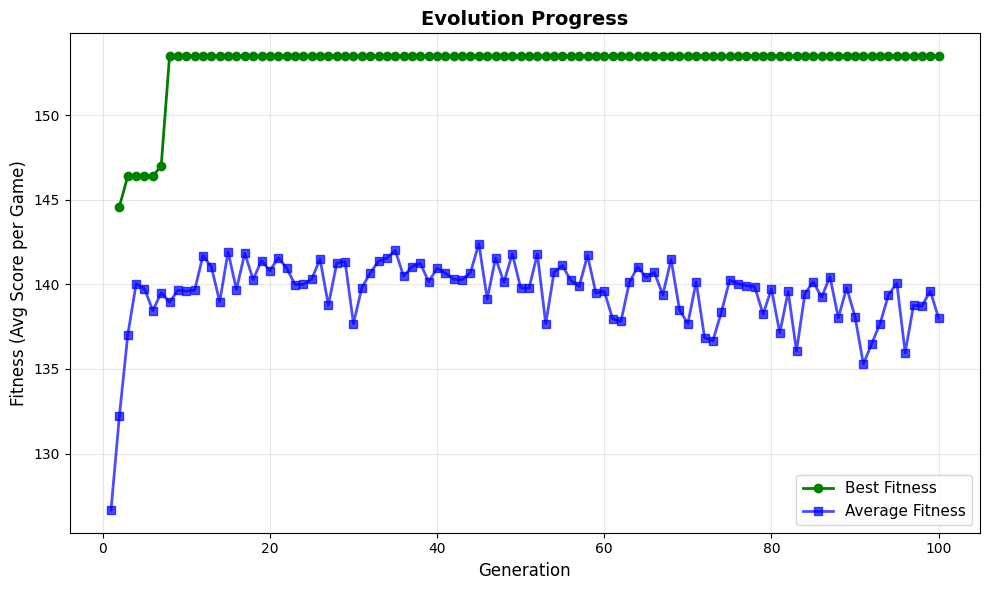


🎉 Your evolved agent's final genes:
   [1.0, 0.4550925917011942, 0.26329409707067997, 0.9696720559401232, 0.0, 0.32173924601759696]


In [7]:

# ============================================================================
# PART 4: RUN EVOLUTION! 
# ============================================================================

print("\n" + "="*70)
print("🚀 TIME TO EVOLVE YOUR AGENT!")
print("="*70)

# TODO: Experiment with these parameters to find the best agent!
my_evolved_agent = evolve(
    generations=100,       # Try: 50, 100, 250
    pop_size=30,         # Try: 15, 20, 30
    opponents=opponent_pool,
    mutation_rate=0.1,  # Try: 0.1, 0.15, 0.2
    elitism=2            # Keep top 2 agents each generation
)

print(f"\n🎉 Your evolved agent's final genes:")
print(f"   {my_evolved_agent.genes}")



In [8]:

# ============================================================================
# PART 5: TEST YOUR AGENT
# ============================================================================

print("\n" + "="*70)
print("⚔️  TESTING YOUR AGENT AGAINST HAND-CODED OPPONENTS")
print("="*70 + "\n")

wins = 0
losses = 0
ties = 0

for opponent in opponent_pool:
    game = Game(my_evolved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    
    if my_score > opp_score:
        result = "✅ WON"
        wins += 1
    elif my_score < opp_score:
        result = "❌ LOST"
        losses += 1
    else:
        result = "🤝 TIED"
        ties += 1
    
    print(f"vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\n📊 Record: {wins} wins, {losses} losses, {ties} ties")
win_rate = wins / len(opponent_pool) * 100
print(f"🎯 Win Rate: {win_rate:.1f}%")




⚔️  TESTING YOUR AGENT AGAINST HAND-CODED OPPONENTS

vs Random (0.5)             : 187 - 257  ❌ LOST
vs Suspicious Tit-for-Tat   : 241 - 246  ❌ LOST
vs Random (0.9)             : 358 - 173  ✅ WON
vs Gradual                  : 154 - 309  ❌ LOST
vs Pavlov                   : 192 - 282  ❌ LOST
vs Hard Majority            : 345 - 185  ✅ WON
vs Random (0.7)             : 279 - 224  ✅ WON
vs Tit-for-Two-Tats         : 296 - 191  ✅ WON
vs Soft Majority            : 344 - 179  ✅ WON
vs Adaptive                 : 301 - 206  ✅ WON

📊 Record: 6 wins, 4 losses, 0 ties
🎯 Win Rate: 60.0%


# Unit 5 Part 2: Benchmark Analysis

**After running your initial evolution and benchmark tests, answer these questions.**

---

## Performance Summary

Fill in your benchmark results:

| Opponent | Result (W/L/T) | Your Score | Opp Score |
|----------|----------------|------------|-----------|
| Always Invest |W |376 |186 |
| Always Undercut |L |73 |208 |
| Suspicious Tit-for-Tat |L |234 |239 |
| Hard Majority |L |91 |206 |
| Pavlov |W |239 |204 |
| Tit-for-Two-Tats |W |330 |200 |
| Generous Tit-for-Tat |W |223 |188 |
| Prober |W |224 |214 |
| Random (0.9) |W |337 |212 |
| Random (0.5) |W |246 |196 |
| **Total** | 7 W / 3 L / 0 T | | |

---

## Analysis Questions

### 1. What was your agent's worst loss (greatest point differential) and why?
My agent's greatest loss was against Always Undercut. It lost 73 to 208 (a 135-point difference). Always Undercut defects every single round, meaning its cooperation rate is always 0%. In my agent’s logic, when the opponent’s cooperation rate drops below 50%, it retaliates with probability Gene[2]. This allowed Always Undercut to exploit my cooperation every time it occurred, which created a large point difference.

---

### 2. What pattern do you see in wins vs. losses?

My agent performs well against cooporative agents. These opponents maintain cooperation rates above 50%, which triggers my agent’s Gene[1] (cooperation response). My agent struggles against aggressive or strategically reactive agents like Always Undercut, Hard Majority, and Suspicious Tit-for-Tat.

---

### 3. What would make an agent more competitive?

To make my agent more competitive I would make it respond more agressivly to constant defection from the opponent. I would make it so that it would always undercut after a certain amount of repeated undercuts and then I would only stop undercutting if they stopped. 

---

**Next:** Proceed to Part 3 to implement your improvements!

In [9]:

# ============================================================================
# PART 6: IMPROVE YOUR AGENT'S ACTION TAKING STRATEGY
# ============================================================================

class ImprovedEvolvableAgent(Agent):
    """
    IMPROVED agent with better gene encoding
    
    Students can modify:
    - Number of genes (currently 6, could add more)
    - What genes control
    - Decision logic (how genes map to actions)
    """
    
    def __init__(self, genes=None, name="Improved Agent"):
        if genes is None:
            # TODO: Students can change number of genes here
            genes = [random.random() for _ in range(6)]
        
        self.genes = genes
        super().__init__(name, f"Genes: [{', '.join([f'{g:.2f}' for g in genes])}]")
    
    def choose_action(self) -> bool:
        """
        IMPROVED decision logic - AGGRESSIVE VERSION
        More likely to retaliate, less exploitable
        """
        
        # First 3 rounds: use initial cooperation gene
        if self.round_num < 3:
            return random.random() < self.genes[0]
        
        # Calculate memory window
        memory_length = max(1, int(self.genes[4] * 10) + 1)
        recent_history = self.history[-memory_length:]
        cooperation_rate = sum(recent_history) / len(recent_history)
        
        # AGGRESSIVE STRATEGY: Higher threshold for cooperation
        
        # Only cooperate if opponent is VERY cooperative (>80%)
        if cooperation_rate > 0.8:
            return random.random() < self.genes[1]  # gene[1] should evolve HIGH
        
        # If somewhat cooperative (50-80%), be cautious
        elif cooperation_rate > 0.5:
            # Mix of cooperation and defection
            coop_prob = self.genes[1] * (cooperation_rate - 0.5) * 2  # Scale 0-1
            return random.random() < coop_prob
        
        # If aggressive (<50%), retaliate hard
        else:
            # Mostly defect, with small chance to forgive
            if random.random() < self.genes[3] * 0.3:  # Reduced forgiveness
                return INVEST
            else:
                return UNDERCUT
    
    def save_to_file(self, filename):
        """Save agent to JSON"""
        data = {
            'name': self.name,
            'genes': self.genes,
            'description': self.description
        }
        with open(filename, 'w') as f:
            json.dump(data, f, indent=2)
        print(f"✅ Agent saved to {filename}")


🔧 EVOLVING YOUR IMPROVED AGENT!

🧬 EVOLUTION STARTING (Improved Agent)
Population: 20 | Generations: 50 | Mutation: 0.1
Opponents: 10 | Elitism: 2

Gen   1/50: Best=144.40 | Avg=124.31 | Genes=['0.55', '0.66', '0.42', '0.66', '0.18', '0.50']
Gen   2/50: Best=144.40 | Avg=129.28 | Genes=['0.64', '0.72', '0.59', '0.58', '0.02', '0.61']
Gen   3/50: Best=145.40 | Avg=131.72 | Genes=['0.64', '0.72', '0.42', '0.66', '0.18', '0.50']
Gen   4/50: Best=145.40 | Avg=131.90 | Genes=['0.77', '0.94', '0.52', '0.66', '0.18', '0.61']
Gen   5/50: Best=145.40 | Avg=137.44 | Genes=['0.70', '0.94', '0.52', '0.05', '0.02', '0.62']
Gen   6/50: Best=145.40 | Avg=139.03 | Genes=['1.00', '0.96', '0.52', '0.05', '0.02', '0.62']
Gen   7/50: Best=146.20 | Avg=140.08 | Genes=['0.70', '1.00', '0.69', '0.66', '0.18', '0.31']
Gen   8/50: Best=146.20 | Avg=138.68 | Genes=['0.96', '1.00', '0.69', '0.05', '0.17', '0.62']
Gen   9/50: Best=147.60 | Avg=142.05 | Genes=['1.00', '0.84', '0.72', '0.37', '0.18', '0.61']
Gen  

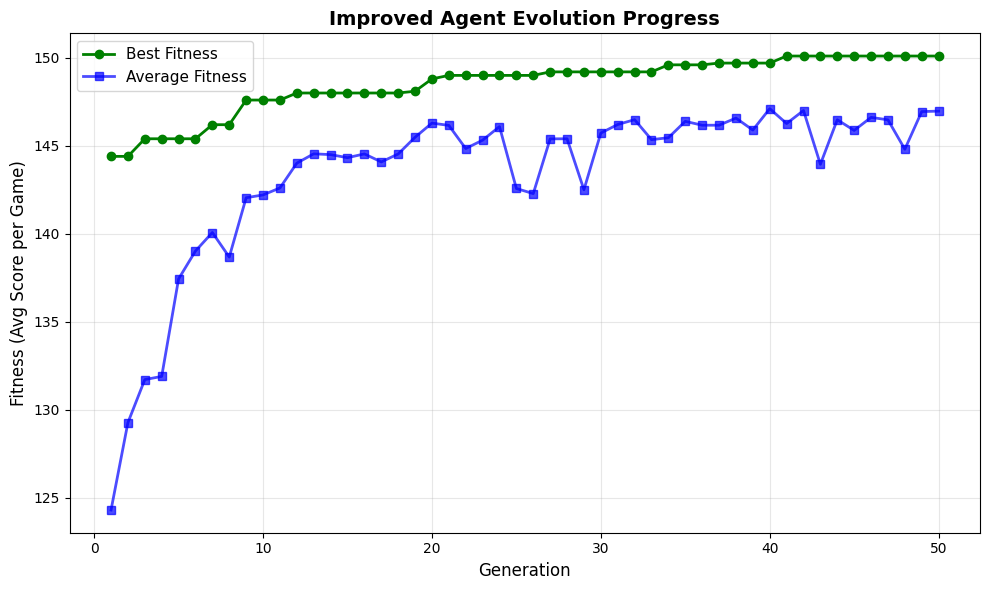


🎉 Your improved agent's final genes:
   [1.0, 1.0, 0.37187168181964114, 0.0, 0.17792577502336038, 0.34810823929864965]


In [10]:
# ============================================================================
# PART 7: EVOLVE YOUR IMPROVED AGENT
# ============================================================================


print("\n" + "="*70)
print("🔧 EVOLVING YOUR IMPROVED AGENT!")
print("="*70)


def evolve_improved(generations=25, pop_size=20, opponents=None, mutation_rate=0.15, elitism=2):
    """
    Evolve using the ImprovedEvolvableAgent class
    (Same as evolve() but uses ImprovedEvolvableAgent instead of EvolvableAgent)
    """
    if opponents is None:
        opponents = opponent_pool
    
    print(f"\n🧬 EVOLUTION STARTING (Improved Agent)")
    print(f"{'='*70}")
    print(f"Population: {pop_size} | Generations: {generations} | Mutation: {mutation_rate}")
    print(f"Opponents: {len(opponents)} | Elitism: {elitism}")
    print(f"{'='*70}\n")
    
    best_fitness_history = []
    avg_fitness_history = []
    
    # Initialize population with ImprovedEvolvableAgent
    population = [ImprovedEvolvableAgent(name=f"Agent_{i}") for i in range(pop_size)]
    
    best_overall_agent = None
    best_overall_fitness = -float('inf')
    
    for gen in range(generations):
        # Evaluate fitness
        fitnesses = []
        for agent in population:
            fitness = evaluate_fitness(agent, opponents, num_rounds=50)
            fitnesses.append(fitness)
        
        # Track best
        best_fitness = max(fitnesses)
        avg_fitness = sum(fitnesses) / len(fitnesses)
        
        # Update best overall
        best_idx = fitnesses.index(best_fitness)
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_agent = ImprovedEvolvableAgent(genes=population[best_idx].genes.copy())
        
        best_fitness_history.append(best_overall_fitness)
        avg_fitness_history.append(avg_fitness)
        
        print(f"Gen {gen+1:3d}/{generations}: "
              f"Best={best_overall_fitness:6.2f} | Avg={avg_fitness:6.2f} | "
              f"Genes={[f'{g:.2f}' for g in population[best_idx].genes]}")
        
        # Create next generation
        if gen < generations - 1:
            sorted_indices = sorted(range(len(fitnesses)), 
                                  key=lambda i: fitnesses[i], 
                                  reverse=True)
            
            # Elitism
            next_population = []
            for i in range(elitism):
                elite_genes = population[sorted_indices[i]].genes.copy()
                next_population.append(ImprovedEvolvableAgent(genes=elite_genes))
            
            # Selection
            selected = tournament_selection(population, fitnesses)
            
            # Crossover and mutation
            while len(next_population) < pop_size:
                parent1, parent2 = random.sample(selected, 2)
                child = crossover_and_mutate(parent1, parent2, mutation_rate)
                # Convert to ImprovedEvolvableAgent
                next_population.append(ImprovedEvolvableAgent(genes=child.genes))
            
            population = next_population
    
    print(f"\n{'='*70}")
    print(f"✅ EVOLUTION COMPLETE!")
    print(f"🏆 Best fitness achieved: {best_overall_fitness:.2f}")
    print(f"{'='*70}\n")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, generations+1), best_fitness_history, 
             label='Best Fitness', linewidth=2, color='green', marker='o')
    plt.plot(range(1, generations+1), avg_fitness_history, 
             label='Average Fitness', linewidth=2, color='blue', marker='s', alpha=0.7)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness (Avg Score per Game)', fontsize=12)
    plt.title('Improved Agent Evolution Progress', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_overall_agent


# TODO: Experiment with these parameters to find the best improved agent!
my_improved_agent = evolve_improved(
    generations=50,      # Try: 20, 30, 50
    pop_size=20,         # Try: 15, 20, 30
    opponents=opponent_pool,
    mutation_rate=0.1,   # Try: 0.1, 0.15, 0.2
    elitism=2            # Keep top 2 agents each generation
)

print(f"\n🎉 Your improved agent's final genes:")
print(f"   {my_improved_agent.genes}")

In [18]:

# ============================================================================
# PART 8.1: Compare: Original vs Improved
# ============================================================================

print("\n" + "="*70)
print("📊 COMPARISON: Original vs Improved Agent")
print("="*70 + "\n")

print("ORIGINAL AGENT:")
wins_orig = 0
for opponent in opponent_pool:
    game = Game(my_evolved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    if my_score > opp_score:
        wins_orig += 1
        result = "✅ WON"
    elif my_score < opp_score:
        result = "❌ LOST"
    else:
        result = "🤝 TIED"
    print(f"vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\nOriginal Win Rate: {wins_orig / len(opponent_pool) * 100:.1f}%")

print("\n" + "-"*70 + "\n")

print("IMPROVED AGENT:")
wins_improved = 0
for opponent in opponent_pool:
    game = Game(my_improved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    if my_score > opp_score:
        wins_improved += 1
        result = "✅ WON"
    elif my_score < opp_score:
        result = "❌ LOST"
    else:
        result = "🤝 TIED"
    print(f"vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\nImproved Win Rate: {wins_improved / len(opponent_pool) * 100:.1f}%")

print("\n" + "="*70)
print(f"📈 IMPROVEMENT: +{wins_improved - wins_orig} wins")
print("="*70)


# ============================================================================
# GENERALIZATION TEST: Full Opponent Pool
# ============================================================================

print("\n" + "="*70)
print("🌍 GENERALIZATION TEST: Against ALL Possible Opponents")
print("="*70 + "\n")

print("Testing improved agent against the FULL opponent library:")
print("(including agents it was NOT trained on)\n")

wins_full = 0
losses_full = 0
ties_full = 0

for opponent in full_opponent_pool:
    game = Game(my_improved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    
    if my_score > opp_score:
        result = "✅ WON"
        wins_full += 1
    elif my_score < opp_score:
        result = "❌ LOST"
        losses_full += 1
    else:
        result = "🤝 TIED"
        ties_full += 1
    
    # Mark if this was a training opponent
    trained_on = "📚" if any(opponent.name == o.name for o in opponent_pool) else "🆕"
    print(f"{trained_on} vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\n📊 Results against ALL {len(full_opponent_pool)} opponents:")
print(f"   Wins: {wins_full} | Losses: {losses_full} | Ties: {ties_full}")
print(f"   Win Rate: {wins_full / len(full_opponent_pool) * 100:.1f}%")
print(f"\n💡 Legend: 📚 = Trained on this opponent | 🆕 = Never seen before")
print("="*70)


📊 COMPARISON: Original vs Improved Agent

ORIGINAL AGENT:
vs Random (0.5)             : 237 - 242  ❌ LOST
vs Suspicious Tit-for-Tat   : 232 - 237  ❌ LOST
vs Random (0.9)             : 331 - 171  ✅ WON
vs Gradual                  : 144 - 289  ❌ LOST
vs Pavlov                   : 242 - 217  ✅ WON
vs Hard Majority            : 280 - 210  ✅ WON
vs Random (0.7)             : 305 - 185  ✅ WON
vs Tit-for-Two-Tats         : 320 - 195  ✅ WON
vs Soft Majority            : 355 - 175  ✅ WON
vs Adaptive                 : 268 - 233  ✅ WON

Original Win Rate: 70.0%

----------------------------------------------------------------------

IMPROVED AGENT:
vs Random (0.5)             : 233 - 138  ✅ WON
vs Suspicious Tit-for-Tat   : 297 - 302  ❌ LOST
vs Random (0.9)             : 311 - 251  ✅ WON
vs Gradual                  : 300 - 300  🤝 TIED
vs Pavlov                   : 300 - 300  🤝 TIED
vs Hard Majority            : 300 - 300  🤝 TIED
vs Random (0.7)             : 303 - 208  ✅ WON
vs Tit-for-Two-Tats 

In [19]:

# ============================================================================
# PART 8.2: Compete in your final tournament
# ============================================================================

print("\n" + "="*70)
print("🏆 FULL TOURNAMENT COMPARISON")
print("="*70 + "\n")

# Create tournament with original agent
print("Running tournament with ORIGINAL agent...")
original_tournament_agents = full_opponent_pool + [my_evolved_agent]
original_tournament = Tournament(original_tournament_agents, rounds_per_match=100, num_tournaments=1)
original_tournament.run_tournament()

# Create tournament with improved agent
print("\n" + "-"*70)
print("\nRunning tournament with IMPROVED agent...")
improved_tournament_agents = full_opponent_pool + [my_improved_agent]
improved_tournament = Tournament(improved_tournament_agents, rounds_per_match=100, num_tournaments=1)
improved_tournament.run_tournament()

# Compare rankings
print("\n" + "="*70)
print("📊 TOURNAMENT RESULTS COMPARISON")
print("="*70 + "\n")

original_rankings = original_tournament.get_rankings()
improved_rankings = improved_tournament.get_rankings()

# Find where each agent placed
original_rank = None
improved_rank = None
original_score = None
improved_score = None

for rank, (name, score) in enumerate(original_rankings, 1):
    if name == my_evolved_agent.name:
        original_rank = rank
        original_score = score

for rank, (name, score) in enumerate(improved_rankings, 1):
    if name == my_improved_agent.name:
        improved_rank = rank
        improved_score = score

print(f"ORIGINAL AGENT:")
print(f"  Rank: {original_rank} / {len(original_rankings)}")
print(f"  Total Score: {original_score:,}")
print()
print(f"IMPROVED AGENT:")
print(f"  Rank: {improved_rank} / {len(improved_rankings)}")
print(f"  Total Score: {improved_score:,}")
print()
print(f"IMPROVEMENT:")
print(f"  Rank Change: {original_rank - improved_rank} positions {'⬆️' if improved_rank < original_rank else '⬇️' if improved_rank > original_rank else '➡️'}")
print(f"  Score Change: +{improved_score - original_score:,} points ({(improved_score - original_score)/original_score*100:.1f}%)")
print("="*70)

# Show full leaderboard
print("\n🏆 IMPROVED AGENT TOURNAMENT LEADERBOARD:")
print("=" * 50)
for rank, (name, score) in enumerate(improved_rankings, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    marker = " ⭐ YOUR AGENT" if name == my_improved_agent.name else ""
    print(f"{emoji} {rank:2d}. {name:25s}: {score:,} points{marker}")


🏆 FULL TOURNAMENT COMPARISON

Running tournament with ORIGINAL agent...
Running 1 tournament(s) with 19 agents...
Match 1/342: Always Invest vs Tit-for-Tat
Match 2/342: Always Invest vs Grim Trigger
Match 3/342: Always Invest vs Pavlov
Match 4/342: Always Invest vs Tit-for-Two-Tats
Match 5/342: Always Invest vs Generous Tit-for-Tat
Match 6/342: Always Invest vs Adaptive
Match 7/342: Always Invest vs Always Undercut
Match 8/342: Always Invest vs Suspicious Tit-for-Tat
Match 9/342: Always Invest vs Gradual
Match 10/342: Always Invest vs Prober
Match 11/342: Always Invest vs Hard Majority
Match 12/342: Always Invest vs Soft Majority
Match 13/342: Always Invest vs Random (0.9)
Match 14/342: Always Invest vs Random (0.7)
Match 15/342: Always Invest vs Random (0.5)
Match 16/342: Always Invest vs Random (0.3)
Match 17/342: Always Invest vs Random (0.1)
Match 18/342: Always Invest vs Evolved Agent
Match 19/342: Tit-for-Tat vs Always Invest
Match 20/342: Tit-for-Tat vs Grim Trigger
Match 21/34

In [20]:
# ============================================================================
# PART 9: Export Complete Agent as Python Module
# ============================================================================

import inspect
from datetime import datetime

def export_complete_agent(agent, student_name, generations=100, final_fitness=None):
    """
    Export agent as a complete, standalone Python module.
    This preserves BOTH genes AND decision logic so your strategy maintains
    its competitive edge in the tournament!
    
    Args:
        agent: Your evolved ImprovedEvolvableAgent
        student_name: Your name (will be used in class name, e.g., "JohnSmith")
        generations: Number of generations you evolved for
        final_fitness: Your agent's final fitness score (optional)
    
    Returns:
        filename of the exported Python file
    """
    
    # Clean up student name for valid Python class name (remove spaces, special chars)
    clean_name = ''.join(c for c in student_name if c.isalnum())
    
    # Get the actual decision logic code
    decision_code = inspect.getsource(agent.choose_action)
    
    # The source code already has proper indentation from the class,
    # so we don't need to add extra indentation
    
    # Get training opponent names if available
    try:
        opponent_names = [opp.name for opp in opponent_pool]
        opponent_info = f"Trained against: {', '.join(opponent_names[:5])}{'...' if len(opponent_names) > 5 else ''}"
    except:
        opponent_info = "Training opponents: [info not available]"
    
    # Build the complete Python module
    code = f'''#!/usr/bin/env python
"""
Tournament Agent: {agent.name}
Student: {student_name}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

Evolution Details:
- Generations: {generations}
- Final Fitness: {final_fitness if final_fitness else 'N/A'}
- {opponent_info}

Strategy: {agent.description}
"""

from agents import Agent, INVEST, UNDERCUT
import random


class {clean_name}Agent(Agent):
    """
    {agent.name}
    
    {agent.description}
    
    Evolved Genes: {agent.genes}
    """
    
    def __init__(self):
        # These genes were evolved through {generations} generations
        self.genes = {agent.genes}
        
        # Required for tournament compatibility
        self.student_name = "{student_name}"
        
        super().__init__(
            name="{agent.name}",
            description="{agent.description}"
        )
    
{decision_code}


# Convenience function for tournament loading
def get_agent():
    """Return an instance of this agent for tournament use"""
    return {clean_name}Agent()


if __name__ == "__main__":
    # Test that the agent can be instantiated
    agent = get_agent()
    print(f"✅ Agent loaded successfully: {{agent.name}}")
    print(f"   Genes: {{agent.genes}}")
    print(f"   Description: {{agent.description}}")
'''
    
    # Save to file
    filename = f"{clean_name.lower()}_tournament_agent.py"
    with open(filename, 'w') as f:
        f.write(code)
    
    print("="*70)
    print("✅ COMPLETE TOURNAMENT AGENT EXPORTED!")
    print("="*70)
    print(f"📄 File: {filename}")
    print(f"🏷️  Class: {clean_name}Agent")
    print(f"🧬 Genes: {agent.genes}")
    print()
    print("📦 What's included:")
    print("   ✓ Your evolved gene values")
    print("   ✓ Your complete decision logic (choose_action method)")
    print("   ✓ All metadata and documentation")
    print()
    print("🎯 Next Steps:")
    print(f"   1. Download '{filename}' from Jupyter")
    print("   2. Submit this .py file for the Unit 6 tournament")
    print("   3. Your strategy will compete exactly as it evolved!")
    print()
    print("🧪 Test your export:")
    print(f"   from {filename[:-3]} import get_agent")
    print("   my_agent = get_agent()")
    print("="*70)
    
    return filename


# ============================================================================
# RUN THIS: Export your improved agent
# ============================================================================

print("\n" + "="*70)
print("💾 EXPORTING YOUR TOURNAMENT AGENT")
print("="*70 + "\n")

# TODO: Customize these fields with your information
STUDENT_NAME = "Marlee Heiken"  # <-- CHANGE THIS! (e.g., "JohnSmith" or "Alex_Chen")

# TODO: Give your agent a creative name and description
my_improved_agent.name = "Improved Agent"  # <-- CHANGE THIS! (e.g., "Vengeful Cooperator", "Strategic Punisher")
my_improved_agent.description = "Cooperates with cooperative opponents but retaliates harshly against defectors"  # <-- CHANGE THIS! (e.g., "Cooperates with cooperative opponents but retaliates quickly against defectors")

print(f"Agent Name: {my_improved_agent.name}")
print(f"Description: {my_improved_agent.description}")
print(f"Genes: {[f'{g:.2f}' for g in my_improved_agent.genes]}\n")

# Export with all the context
exported_file = export_complete_agent(
    agent=my_improved_agent,
    student_name=STUDENT_NAME,
    generations=100,  # Update if you used different value
    final_fitness=None  # Optionally add your best fitness score (e.g., 85.2)
)

print(f"\n✨ Your agent is ready for tournament competition!")
print(f"   Unlike JSON exports, this preserves your evolved strategy.\n")



💾 EXPORTING YOUR TOURNAMENT AGENT

Agent Name: Improved Agent
Description: Cooperates with cooperative opponents but retaliates harshly against defectors
Genes: ['1.00', '1.00', '0.37', '0.00', '0.18', '0.35']

✅ COMPLETE TOURNAMENT AGENT EXPORTED!
📄 File: marleeheiken_tournament_agent.py
🏷️  Class: MarleeHeikenAgent
🧬 Genes: [1.0, 1.0, 0.37187168181964114, 0.0, 0.17792577502336038, 0.34810823929864965]

📦 What's included:
   ✓ Your evolved gene values
   ✓ Your complete decision logic (choose_action method)
   ✓ All metadata and documentation

🎯 Next Steps:
   1. Download 'marleeheiken_tournament_agent.py' from Jupyter
   2. Submit this .py file for the Unit 6 tournament
   3. Your strategy will compete exactly as it evolved!

🧪 Test your export:
   from marleeheiken_tournament_agent import get_agent
   my_agent = get_agent()

✨ Your agent is ready for tournament competition!
   Unlike JSON exports, this preserves your evolved strategy.



## Post-Evolution Reflection Questions

### 1. Generalization Analysis
- Compare your agent's performance on training opponents (📚) vs. unseen opponents (🆕)
    - It seemed to actually do better agains the unseen opponents
- Did your agent generalize well or overfit to the training set?
    - Since it did better against unseen agents, my agent seems to generalize well and isn't just tailored to a specific opponent.
- What does this suggest about evolving against a random sample vs. fixed opponents?
    - This suggests that diverse, random sampling helps the agent to evolve better, more general strategies that perform well against more agents. 

### 2. Tournament Performance
- What was your agent's final tournament rank? 6 out of 19
- What was your agent's total score? 4,675
- Look at agents that ranked above and below you - what strategies do they use? 
    - They tend to be cooperative or sophisticated agents, which is interesting because my first agent only seemed to lose to non coperative agents, which I think is becuse my agent was too forgiving. But now I am losing to the ones that are more forgiving to me, so I probably need to find a better middle ground of cooperativeness.

### 3. Strategy Analysis
Look at your evolved genes: ['1.00', '1.00', '0.37', '0.00', '0.18', '0.35']

- In plain English, what strategy did your agent evolve?
    - my agent starts nice and cooperates in the first rounds, which is the same as the original agent, but it evolved to 0 in the forgiveness gene and respondes very agressivly once it decides you are agressive. 
- Does it cooperate with cooperators? Does it punish defectors?
    - It does cooperate with cooperators and it responds strongluy to defectors. 
- Why do you think evolution discovered this particular strategy?
    - I think it discoveded this strategy because originally it was losing to agents for being too forgiving so it had to learn to be less forgiving. 

### 4. Trade-offs
Every strategy has strengths and weaknesses.

- Which types of opponents does your agent beat?
    - My agent seems like it mostly beats non cooperative agents, which I think is because my agent retaliates harshly to agents that undercut a lot.
- Which types beat your agent?
    - It appears to lost most often to cooperative or sophisticated agents, which I think is becuse my agent was too forgiving originaly.
- If you could redesign your agent for Unit 6, what would you change?
    - I would try to find a better middle groud where it keeps its harsh responses to agents who undercut a lot, but is more forgiving to those who change their ways. 

### 5. The Environment Matters
- You evolved against a random sample of 10 opponents
- The tournament included all 19 opponents
- Unit 6 will include 30+ student agents with unpredictable strategies
- How might your agent perform in that different environment?
    - If I face 30+ oponents all of whom are an agent type that my agent struggles with, then I may do much worse. 